<a href="https://colab.research.google.com/github/thibaud-perrin/vision-language-models/blob/main/notebooks/vlm_sft_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning a Vision Language Model (VLM)

This notebook showcases how to fine-tune the `SmolVLM-Instruct` model using the `SFTTrainer` from the `trl` library. The process involves preparing a dataset, configuring the trainer, and running the fine-tuning process to adapt the model for specific tasks.


## Secrets
Loading HuggingFace secret and login to huggingFace

In [1]:
from google.colab import userdata
TOKEN = userdata.get('HF_TOKEN')

In [2]:
# Authenticate to Hugging Face
from huggingface_hub import login
login(token=TOKEN)

## Libraries

In [3]:
# Install the requirements in Google Colab
!pip install transformers datasets trl huggingface_hub accelerate bitsandbytes

In [4]:
# Import dependencies
import torch
import os
from transformers import AutoProcessor, AutoModelForVision2Seq, BitsAndBytesConfig
from transformers.image_utils import load_image

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_use_double_quant=True,
                                         bnb_4bit_quant_type="nf4",
                                         bnb_4bit_compute_dtype=torch.bfloat16)
model_name = "HuggingFaceTB/SmolVLM-Instruct"
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
).to(device)
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")

# Set our name for the finetune to be saved &/ uploaded to
finetune_name = "SmolVLM-FT-MyDataset"
finetune_tags = ["smol-course", "module_5"]

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


## Dataset Preparation
We start by loading and formatting a sample dataset for fine-tuning. The dataset is structured as input-output pairs, where each input is a prompt (e.g., a question or image description), and the output is the expected response from the model.

To align with the model’s requirements, input messages are formatted as a list of dictionaries with keys `role` and `content`. These formats are crucial for integrating with the model’s chat templates, enabling smooth processing during training.


In [6]:
# Load a sample dataset
from datasets import load_dataset

dataset_name = "HuggingFaceM4/ChartQA"
ds = load_dataset(path=dataset_name)
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 28299
    })
    val: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 1920
    })
    test: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 2500
    })
})

In [7]:
ds["train"] = ds["train"].select(range(1000))
ds["test"] = ds["test"].select(range(1000))
ds["val"] = ds["val"].select(range(1000))

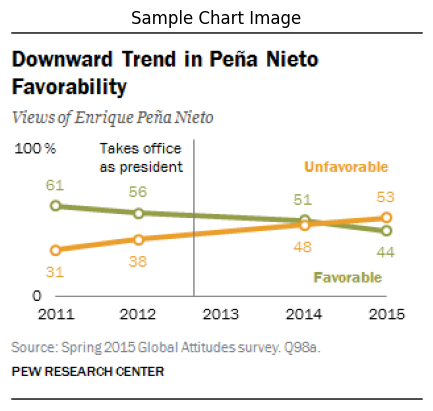

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=314x281 at 0x78E61024AF90>, 'query': 'What is the sum favourable  value in the year 2014 and 2015?', 'label': ['95'], 'human_or_machine': 0, 'image_size': ((314, 281),)}
Query: What is the sum favourable  value in the year 2014 and 2015?
Expected Answer: 95
Model Prediction: User:<image>What is the sum favourable  value in the year 2014 and 2015?
Answer: 91.


In [8]:
import matplotlib.pyplot as plt
sample = ds['train'][3]

# Display the structure of a single sample
sample['image_size'] = sample['image'].size,

# Visualize the image and related metadata
plt.imshow(sample['image'])
plt.axis("off")
plt.title("Sample Chart Image")
plt.show()

print(sample)

# Preprocess the sample
prompt = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": sample["query"]}]}]
formatted_query = processor.apply_chat_template(prompt, tokenize=False)

inputs = processor(
    images=sample["image"],
    text=formatted_query,
    return_tensors="pt"
).to(device)
inputs = {key: val.to(device, dtype=torch.bfloat16) if val.dtype == torch.float else val.to(device) for key, val in inputs.items()}

# Generate predictions
with torch.no_grad():
    outputs = model.generate(**inputs,
                             max_length=1600)

# Decode the prediction
prediction = processor.batch_decode(outputs, skip_special_tokens=True)

# Display the result
print(f"Query: {sample['query']}")
print(f"Expected Answer: {sample['label'][0]}")
print(f"Model Prediction: {prediction[0]}")

## Set Up LoRA

In [9]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 2,568,192 || all params: 2,248,841,072 || trainable%: 0.1142


## Configuring the Trainer
Next, we set up the `SFTTrainer` with essential parameters to control the training process. This includes:
- Number of training steps
- Batch size
- Learning rate
- Evaluation strategy

These configurations are flexible and can be adjusted based on the size of your dataset, available hardware, and desired training outcomes.


In [10]:
def collate_fn(examples):
    # System message template for the VLM
    system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
    Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
    The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
    Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

    # Initialize lists for text and image inputs
    text_inputs = []
    image_inputs = []

    # Process all examples in one loop
    for example in examples:
        # Format the chat structure for the processor
        formatted_example = {
            "messages": [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                        },
                        {
                            "type": "text",
                            "text": example["query"],
                        },
                    ],
                },
            ]
        }
        # Apply chat template and strip extra spaces
        text_inputs.append(processor.apply_chat_template(formatted_example["messages"], tokenize=False).strip())

        # Ensure images are in RGB mode
        image = example["image"]
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image_inputs.append( [image] )

    # Tokenize the texts and process the images
    batch = processor(
        text=text_inputs,
        images=image_inputs,
        return_tensors="pt",
        padding=True
    )

    # Clone input IDs for labels
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    # Ensure image_token is converted to string if it is an AddedToken
    # In some processor, processor.image_token return a list for each image.
    # Warning: AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct") only have one ?
    image_token_id = processor.tokenizer.convert_tokens_to_ids(str(processor.image_token))

    # Mask image token IDs in the labels
    labels[labels == image_token_id] = -100

    # Add labels back to the batch
    batch["labels"] = labels


    return batch


In [11]:
from trl import SFTConfig, SFTTrainer

# Configure the Trainer
training_args = SFTConfig(
    output_dir="sft_output",  # Directory to save the model
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=2,          # batch size per device during training
    gradient_accumulation_steps=16,         # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=5,                        # log every 5 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=False,
    report_to="none",  # Disable external logging
    # push model to hub
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    # dataloader_num_workers=16,
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True}, # important for collator
    remove_unused_columns = False                    # necessary else features except label will be removed
)
# Initialize the Trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

## Training the Model
Finally, we train the model using the configured trainer. The training loop iterates over the dataset, computes the loss, and updates the model’s parameters to minimize this loss. The goal is to adapt the pre-trained VLM to your specific task while maintaining its general capabilities.


In [12]:
# Train the model
trainer.train()

# Save the model
trainer.save_model(f"./{finetune_name}")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
5,27.457100
10,24.424500
15,21.990500
20,19.498300
25,16.552100
30,13.367700
35,8.118300
40,6.331100
45,4.148900
50,3.353500


## Test the Model
Test our fine tune model on the validation dataset

In [30]:
fine_tuned_model_path = f"./{finetune_name}"
trained_model = AutoModelForVision2Seq.from_pretrained(
    fine_tuned_model_path,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
).to(device)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


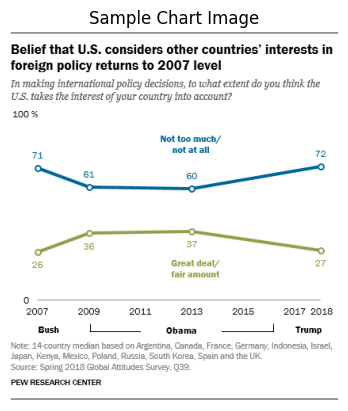

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=415x467 at 0x78E5A026F950>, 'query': 'What is the max value of blue line?', 'label': ['0.72'], 'human_or_machine': 0, 'image_size': ((415, 467),)}
Query: What is the max value of blue line?
Expected Answer: 0.72
Model Prediction: User:<image>What is the max value of blue line?
Assistant: 72.


In [31]:
sample = ds['val'][3]

# Display the structure of a single sample
sample['image_size'] = sample['image'].size,

# Visualize the image and related metadata
plt.imshow(sample['image'])
plt.axis("off")
plt.title("Sample Chart Image")
plt.show()

print(sample)

# Preprocess the sample
prompt = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": sample["query"]}]}]
formatted_query = processor.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)

inputs = processor(
    images=sample["image"],
    text=formatted_query,
    return_tensors="pt"
).to(device)
inputs = {key: val.to(device, dtype=torch.bfloat16) if val.dtype == torch.float else val.to(device) for key, val in inputs.items()}

# Generate predictions
with torch.no_grad():
    outputs = trained_model.generate(**inputs, max_new_tokens=100, num_beams=5, temperature=0.7, do_sample=True, use_cache=True)

# Decode the prediction
prediction = processor.batch_decode(outputs, skip_special_tokens=True)

# Display the result
print(f"Query: {sample['query']}")
print(f"Expected Answer: {sample['label'][0]}")
print(f"Model Prediction: {prediction[0]}")

By the end of this notebook, we now have a fine-tuned version of `SmolVLM-Instruct`, ready to tackle specialized tasks with improved performance.






